# Process immunogenicity data

We will process immunogenicity training data from the following papers:
- Prime 2.0

The processed data will be saved in the `processed/immunogenicity` directory.

### Data processing steps
- Only use HLA class I (genes A, B and C)
- Normalize HLA alleles names to HLA-A02-01 format
- Compute data splits
- Transform the data to have the following columns: `peptide, is_mono_allelic, hla_allele, label, split`

In [1]:
import os
import random
import pandas as pd
from tqdm import tqdm
from collections import defaultdict

In [2]:
DATA_DIR = '../data'
RAW_DATA_DIR = os.path.join(DATA_DIR, 'raw')
INTERIM_DATA_DIR = os.path.join(DATA_DIR, 'interim')
PROCESSED_DATA_DIR = os.path.join(DATA_DIR, 'processed')
RAW_IMMUNOGENICITY_DATA_DIR = os.path.join(RAW_DATA_DIR, 'pHLA_immunogenicity')
INTERIM_IMMUNOGENICITY_DATA_DIR = os.path.join(INTERIM_DATA_DIR, 'pHLA_immunogenicity')
PROCESSED_IMMUNOGENICITY_DATA_DIR = os.path.join(PROCESSED_DATA_DIR, 'immunogenicity')

os.makedirs(INTERIM_IMMUNOGENICITY_DATA_DIR, exist_ok=True)
os.makedirs(PROCESSED_IMMUNOGENICITY_DATA_DIR, exist_ok=True)

### Functions to process data

Copied from this notebook `2.1-amdr-cross-validation-splits-based-on-hobohom.ipynb`

In [3]:
def find_kmers(seq: str, k: int) -> set[str]:
    """
    Returns a set of all k-mers (contiguous substrings of length k) in a given sequence.
    """
    kmers = set()
    for i in range(len(seq) - k + 1):
        kmers.add(seq[i:i+k])
    return kmers


def has_common_kmer(seq1, seq2, k):
    """
    Checks if two sequences share a common k-mer.
    """
    kmers1 = find_kmers(seq1, k)
    kmers2 = find_kmers(seq2, k)
    return bool(kmers1.intersection(kmers2))


def split_common_motif(uniq_sequences, num_folds=5, seed_kmer=5, redundant_kmer=5, balance_splits=False, all_peptides_df=None, rand_seed=42):
    """
    Splits a list of sequences into non-redundant cross-validation folds using
    the "common-motif" procedure.
    """
    # Find seed sequences with no common seed_kmer
    # The bigger the seed_kmer, the more seeds you'll obtain and, 
    #  probably the more similar the seed sequences will be between them
    seed_sequences = []
    print(f'Finding seed sequences of len {seed_kmer}...')
    for seq in tqdm(uniq_sequences):
        is_seed = True
        for seed in seed_sequences:
            if has_common_kmer(seq, seed, seed_kmer):
                is_seed = False
                break
        if is_seed:
            seed_sequences.append(seq)
    print(f'Found {len(seed_sequences)} seed sequences.')
    
    # Assign remaining sequences to each seed. Make a dictionary of seed with all the sequences that includes it
    seed_to_sequences = defaultdict(list)
    assigned_sequences = set()  # To track assigned sequences
    print(f'Assigning sequences to seeds with redundant kmer {redundant_kmer}...')
    for seq in tqdm(uniq_sequences):
        for seed in seed_sequences:
            if has_common_kmer(seq, seed, redundant_kmer):
                if seq not in assigned_sequences:  # Ensure each sequence is only assigned once
                    seed_to_sequences[seed].append(seq)
                    assigned_sequences.add(seq)
                break # assign to the first seed that matches
                
    # Assert that all peptides in seed_to_sequences are only assigned once
    all_assigned_sequences = [seq for seq_list in seed_to_sequences.values() for seq in seq_list]
    assert len(all_assigned_sequences) == len(set(all_assigned_sequences)), 'All peptides should only appear once in seed_to_sequences'
    
    if balance_splits:
        assert all_peptides_df is not None, 'all_peptides_df should be a df with a column called peptide instead of None'
        assert len(all_peptides_df['peptide'].unique()) == len(uniq_sequences), 'all_peptides_df should have the same number of rows as sequences'
        print('Balancing splits')
        # Create a dictionary for peptide counts
        peptide_counts = all_peptides_df['peptide'].value_counts().to_dict()
        # Assign weight to each seed according to the number of sequences assigned to it and its frequency in the dataset
        #seed_weights = {seed: len(seq_list) * peptide_counts.get(seed, 0) for seed, seq_list in seed_to_sequences.items()}
        # Assign weight to each seed according to the sum of the counts of all peptides in seq_list
        seed_weights = {}
        for seed, seq_list in seed_to_sequences.items():
            weight = sum(peptide_counts.get(peptide, 0) for peptide in seq_list)
            # print(f'Seed {seed} has weight {weight} with sequences {seq_list}')
            seed_weights[seed] = weight
        
        # assert that all peptides only appear once in seed_to_sequences
        
        # Sort seeds by their weight in descending order
        sorted_seeds = sorted(seed_weights.items(), key=lambda item: item[1], reverse=True)
        
        # Initialize folds
        folds = [[] for _ in range(num_folds)]
        fold_weights = [0] * num_folds
        
        # Distribute seeds to folds
        for seed, weight in sorted_seeds:
            # Find the fold with the minimum total weight
            min_fold_index = fold_weights.index(min(fold_weights))
            # Assign the seed to this fold
            folds[min_fold_index].append(seed)
            # Update the weight of this fold
            fold_weights[min_fold_index] += weight
            
        # Collect sequences for each fold
        final_folds = [[] for _ in range(num_folds)]
        for fold_idx, seeds in enumerate(folds):
            for seed in seeds:
                final_folds[fold_idx].extend(seed_to_sequences[seed])
        
    else:
        # Randomly assign seeds to folds
        print('Randomly assign ')
        random.seed(rand_seed)
        random.shuffle(seed_sequences)
        final_folds = [[] for _ in range(num_folds)]
        for i, seed in enumerate(seed_sequences):
            fold_idx = i % num_folds
            final_folds[fold_idx].extend(seed_to_sequences[seed])
            
    # Assert that all peptides appear only once across all folds
    all_assigned_sequences = [seq for fold in final_folds for seq in fold]
    assert len(all_assigned_sequences) == len(set(all_assigned_sequences)), 'All peptides should only appear once across all folds'
        
    return final_folds
    

## Process PRIME data

### Process Prime 2.0 data

In [4]:
RAW_PRIME_DATA_DIR = os.path.join(
    RAW_IMMUNOGENICITY_DATA_DIR, 'PRIME'
)
INTERIM_PRIME_DATA_DIR = os.path.join(
    INTERIM_IMMUNOGENICITY_DATA_DIR, 'PRIME'
)
PROCESSED_PRIME_DATA_DIR = os.path.join(
    PROCESSED_IMMUNOGENICITY_DATA_DIR, 'PRIME'
)

train_prime2_file = os.path.join(
    RAW_PRIME_DATA_DIR, 'train_2023_PRIME2.0.csv'
)

N_FOLDS = 5

os.makedirs(INTERIM_PRIME_DATA_DIR, exist_ok=True)
os.makedirs(PROCESSED_PRIME_DATA_DIR, exist_ok=True)

In [5]:
full_train_prime2_df = pd.read_csv(train_prime2_file)
# For debugging
# full_train_prime2_df = pd.read_csv(train_prime2_file)[:1000]
full_train_prime2_df.head()

,Mutant,Allele,MixMHCpred,NetMHCpan,MHCflurry,HLAthena,PRIME1.0,Immunogenicity,SourceProt,Random
0,VMLQAPLFT,A0201,4.44635,2.323,1.32054,8.40544,100.00,0,ANKIB1,0
1,MLIVETAVM,A0201,3.50576,2.504,1.41484,8.40110,100.00,0,ANKIB1,0
2,MLIVETAVML,A0201,4.63429,1.267,1.12003,3.18349,100.00,0,ANKIB1,0
3,VMLQAPLFTA,A0201,1.20439,1.597,0.23345,0.76095,0.90,0,ANKIB1,0
4,LLSECVHAL,A0201,0.00384,0.065,0.00168,0.18895,0.02,0,DDO,0


In [6]:
train_prime2_df = full_train_prime2_df[['Mutant', 'Allele', 'Immunogenicity']]
train_prime2_df.head()

,Mutant,Allele,Immunogenicity
0,VMLQAPLFT,A0201,0
1,MLIVETAVM,A0201,0
2,MLIVETAVML,A0201,0
3,VMLQAPLFTA,A0201,0
4,LLSECVHAL,A0201,0


In [7]:
# Get only HLA class I alleles (A, B, C)
print("Train data shape before filtering by A,B,C genes", train_prime2_df.shape)
train_prime2_df = train_prime2_df[train_prime2_df['Allele'].str.startswith('A') | train_prime2_df['Allele'].str.startswith('B') | train_prime2_df['Allele'].str.startswith('C')]
print("Train data shape after filtering by A,B,C genes", train_prime2_df.shape)

Train data shape before filtering by A,B,C genes (65585, 3)
Train data shape after filtering by A,B,C genes (65585, 3)


In [8]:
# Normalize HLA alleles names from A0201 to HLA-A02-01 format
train_prime2_df['Allele'] = 'HLA-' + train_prime2_df['Allele'].str[:-2] + '-' + train_prime2_df['Allele'].str[-2:]
train_prime2_df.head()

,Mutant,Allele,Immunogenicity
0,VMLQAPLFT,HLA-A02-01,0
1,MLIVETAVM,HLA-A02-01,0
2,MLIVETAVML,HLA-A02-01,0
3,VMLQAPLFTA,HLA-A02-01,0
4,LLSECVHAL,HLA-A02-01,0


In [9]:
# Rename columns
train_prime2_df = train_prime2_df.rename(
    columns = {
        'Allele': 'hla_allele',
        'Mutant': 'peptide',
        'Immunogenicity': 'label'
    }
)
train_prime2_df['is_mono_allelic'] = True
train_prime2_df.head()

,peptide,hla_allele,label,is_mono_allelic
0,VMLQAPLFT,HLA-A02-01,0,True
1,MLIVETAVM,HLA-A02-01,0,True
2,MLIVETAVML,HLA-A02-01,0,True
3,VMLQAPLFTA,HLA-A02-01,0,True
4,LLSECVHAL,HLA-A02-01,0,True


In [10]:
# Compute splits
unique_peptides = train_prime2_df['peptide'].unique()
unique_peptides.shape

(63494,)

In [11]:
folds = split_common_motif(unique_peptides, num_folds=N_FOLDS, balance_splits=True, all_peptides_df=train_prime2_df)

Finding seed sequences of len 5...


100%|██████████| 63494/63494 [18:08<00:00, 58.32it/s] 


Found 22470 seed sequences.
Assigning sequences to seeds with redundant kmer 5...


100%|██████████| 63494/63494 [17:43<00:00, 59.68it/s] 


Balancing splits


In [12]:
for fn, f in enumerate(folds):
    print(f'Fold {fn}: {len(f)}')

Fold 0: 12705
Fold 1: 12678
Fold 2: 12725
Fold 3: 12676
Fold 4: 12710


In [13]:
# Save folds
# for i, fold in enumerate(folds):
#     with open(os.path.join(INTERIM_PRIME_DATA_DIR, f'train_PRIME2_2023_peptides_balanced_split_{i}_of_{N_FOLDS}_splits.txt'), 'w') as f:
#         for peptide in fold:
#             f.write(f'{peptide}\n')

# load folds
folds = []
for i in range(5):
    with open(os.path.join(INTERIM_PRIME_DATA_DIR, f'train_PRIME2_2023_peptides_balanced_split_{i}_of_{N_FOLDS}_splits.txt'), 'r') as f:
        fold = [line.strip() for line in f]
        folds.append(fold)

for fn, f in enumerate(folds):
    print(f'Fold {fn}: {len(f)}')

Fold 0: 12705
Fold 1: 12678
Fold 2: 12725
Fold 3: 12676
Fold 4: 12710


In [14]:
# Recover folds in the original dataframe
peptide_fold_df = train_prime2_df.copy()
peptide_fold_df['split'] = '-'
for i, fold in enumerate(folds): # skip fold 0 since it is already assigned
    for peptide in tqdm(fold):
        peptide_fold_df.loc[peptide_fold_df['peptide'] == peptide, 'split'] = i
        
peptide_fold_df.to_csv(os.path.join(PROCESSED_PRIME_DATA_DIR, 'train_PRIME2_2023_peptides_hla_ABC_with_BalancedSplits.csv'), index=False)

# Load the dataframe with the folds
# peptide_fold_df = pd.read_csv(os.path.join(PROCESSED_PRIME_DATA_DIR, 'train_PRIME2_2023_peptides_hla_ABC_with_BalancedSplits.csv'))

100%|██████████| 12710/12710 [00:32<00:00, 396.32it/s]


In [15]:
peptide_fold_df.groupby('split').size()

split
0    13117
1    13117
2    13117
3    13117
4    13117
dtype: int64

In [16]:
# Num of labels 1 per fold/split
peptide_fold_df.groupby('split')['label'].sum()

split
0    117
1    109
2    114
3    144
4    112
Name: label, dtype: int64

In [17]:
# Num of unique hla per fold
peptide_fold_df.groupby('split')['hla_allele'].nunique()

split
0    60
1    62
2    61
3    62
4    62
Name: hla_allele, dtype: int64

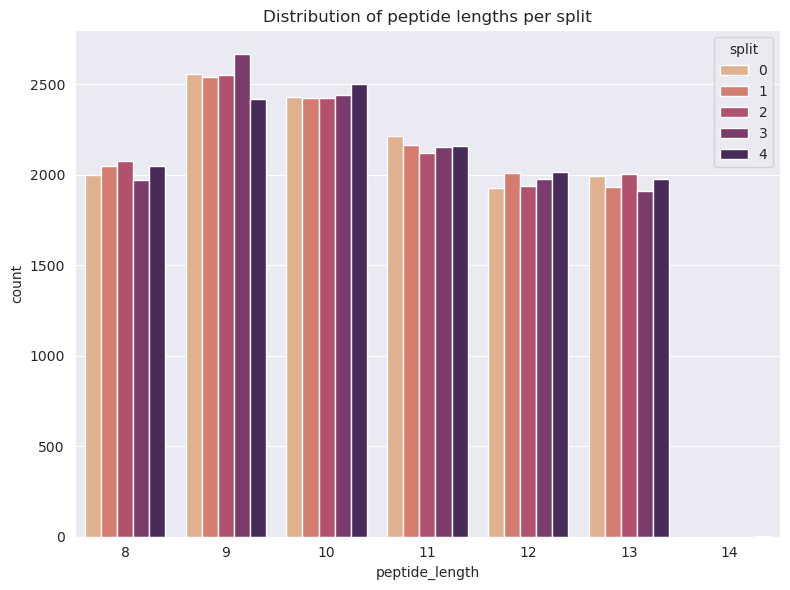

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of peptide lengths per fold
peptide_lengths_df = peptide_fold_df.copy()
peptide_lengths_df['peptide_length'] = peptide_lengths_df['peptide'].apply(len)
plt.figure(figsize=(8, 6))
sns.countplot(peptide_lengths_df, x="peptide_length", hue="split", palette='flare')
plt.title('Distribution of peptide lengths per split')
plt.tight_layout()
plt.savefig(os.path.join('.', 'peptide_lengths_per_fold.png'))
#plt.ylim(0,500)
plt.show()